# Data pre-processing

In [237]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

plt.rcParams['figure.figsize'] = [20, 10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaastra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Gaastra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [238]:
df_all_news = pd.read_csv('data/us_equities_news_dataset.csv')

In [239]:
# Check datatypes in news dataframe
print(f'{df_all_news.dtypes}\n')

# Let convert_dtypes() find best suited dtypes for columns
df_all_news = df_all_news.convert_dtypes()

# Check datatypes in news dataframe after convert_dtypes()
print(f'{df_all_news.dtypes}\n')

# Convert 'release_date' to DateTime object
df_all_news['release_date'] = pd.to_datetime(df_all_news['release_date'], format='%Y-%m-%d')

# Check datatypes in news dataframe after manual fixing
print(f'{df_all_news.dtypes}\n')

id               int64
ticker          object
title           object
category        object
content         object
release_date    object
provider        object
url             object
article_id       int64
dtype: object

id                       Int64
ticker          string[python]
title           string[python]
category        string[python]
content         string[python]
release_date    string[python]
provider        string[python]
url             string[python]
article_id               Int64
dtype: object

id                       Int64
ticker          string[python]
title           string[python]
category        string[python]
content         string[python]
release_date    datetime64[ns]
provider        string[python]
url             string[python]
article_id               Int64
dtype: object



In [240]:
# Count duplicates in 'content' column
print(f"Duplicates found 'content' column: {df_all_news['content'].duplicated().sum()}")
# Remove duplicates in 'content' column
df_all_news.drop_duplicates('content', inplace=True)


# Count NVIDIA related articles
# print(f"NVIDIA related articles: {df_all_news[df_all_news['ticker'] == 'NVDA']['id'].count()}")
# Filter DataFrame on NVIDIA related articles
# df_news = df_all_news[df_all_news['ticker'] == 'NVDA'].copy()

# print(f"NVIDIA related articles: {df_all_news[df_all_news['ticker'] == 'NVDA']['id'].count()}")
# df_news = df_all_news[df_all_news['ticker'] == 'NVDA'].copy()

print(f"NVIDIA related articles: {df_all_news[df_all_news['content'].str.lower().str.contains("nvidia")]['id'].count()}")
df_news = df_all_news[df_all_news['content'].str.lower().str.contains("nvidia")].copy()

# Convert content to all lowercase
df_news['content'] = df_news['content'].apply(str.lower)

# Add 'word_count' column containing word count per article
df_news['word_count'] = df_news.apply(lambda row: len(row.content.split(' ')), axis=1)

Duplicates found 'content' column: 516
NVIDIA related articles: 3384


In [241]:
eng_stopwords = set(stopwords.words('english'))

def tokenize(content):
    tokens = content.split(' ')
    return tokens

def clean_tokens(tokens):
    cleaned = [token for token in tokens if (token != '' and token not in eng_stopwords) and token.isalpha()]
    return cleaned

def join_tokens(tokens):
    return ' '.join(tokens)

# Tokenize 'content' and store in 'tokens'
df_news['tokens'] = df_news['content'].apply(tokenize)

# Clean 'tokens' by removing empty tokens, removing stopwords and removing punctuation and numbers
df_news['tokens'] = df_news['tokens'].apply(clean_tokens)

# Join 'tokens' together and store in 'content'
df_news['content'] = df_news['tokens'].apply(join_tokens)


In [242]:
# Perform pos-tagging on corpus
unique_token_set = set(" ".join(df_news['content']).split(" "))
unique_token_tagged = pos_tag(unique_token_set, tagset='universal')
tag_abbrev_dict = {"NOUN": "n",
                   "VERB": "v",
                   "ADJ": "a",
                   "ADV": "r"}

# Build token/pos-tag dictionary
unique_token_tagged_abbrev = [(token, tag_abbrev_dict[pos_tag]) for (token, pos_tag) in unique_token_tagged if pos_tag in tag_abbrev_dict.keys()]

# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
lemmatized_tokens_dict = {token: lemmatizer.lemmatize(token, pos=pos_tag) for (token, pos_tag) in unique_token_tagged_abbrev}

In [243]:
def lemmatize_content(tokens, lemmatize_dict):
    lemmatized_tokens = [lemmatize_dict[token] if token in lemmatize_dict.keys() else token for token in tokens]
    return ' '.join(lemmatized_tokens)

df_news['content'] = df_news['tokens'].apply(lemmatize_content, lemmatize_dict=lemmatized_tokens_dict)
df_news

,id,ticker,title,category,content,release_date,provider,url,article_id,word_count,tokens
24,221539,NIO,A Central Bank War Just Started And Its Good For Stocks,opinion,ecb move euro huge fall pip huge important piece euro break essential support write thought euro could even fall parity feed may need cut rate later year dovish today outlook much german bunds fel...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-bank-war-just-started-and-its-good-for-stocks-200395687,200395687,784,"[ecb, move, euro, huge, falling, pips, huge, important, piece, euro, broke, essential, support, wrote, thoughts, euro, could, even, fall, parity, fed, may, need, cut, rates, later, year, dovish, t..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,stock watch march trading go pretty much nowhere march p finish day bps modestly surprised stock get boost strong service pmi data come versus estimate one high reading time us forget service indu...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to-watch-for-the-march-6-trading-session-200394931,200394931,618,"[stocks, watch, march, trading, went, pretty, much, nowhere, march, p, finishing, day, bps, modestly, surprised, stocks, get, boost, strong, services, pmi, data, came, versus, estimates, one, high..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple Leads Tech Rout,news,invest com rout apple facebook nasdaq fb monday sweep tech prompt wave sell across broad market dow jones industrial average fell p fell nasdaq composite fell sour faang stock investor digest wall...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-news/stocks--dow-drops-nearly-400-points-as-apple-leads-tech-rout-1694042,1694042,578,"[investing, com, rout, apple, facebook, nasdaq, fb, monday, swept, tech, prompting, wave, selling, across, broader, market, dow, jones, industrial, average, fell, p, fell, nasdaq, composite, fell,..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Micro Devices Intel NVIDIA Qualcomm And Uber,opinion,immediate releasechicago il january zacks com announces list stock feature analyst blog every day zacks equity research analyst discus late news event impact stock financial market stock recently ...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-analyst-blog-highlights-advanced-micro-devices-intel-nvidia-qualcomm-and-uber-200498277,200498277,1849,"[immediate, releasechicago, il, january, zacks, com, announces, list, stocks, featured, analyst, blog, every, day, zacks, equity, research, analysts, discuss, latest, news, events, impacting, stoc..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,company bring innovation ce jan get really difficult pick favorite especially practically everything technology seem consumer item day go day tcl smartphone promising dramatically low cost samsung...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of-ces-2020-revised-200499164,200499164,1515,"[companies, bringing, innovations, ces, jan, gets, really, difficult, pick, favorites, especially, practically, everything, technology, seems, consumer, item, days, gone, days, tcl, smartphone, pr..."
...,...,...,...,...,...,...,...,...,...,...,...
221141,442657,AMD,Here s Why Nvidia NVDA Stock Is Gaining Today,opinion,share nvidia nasdaq nvda nearly tuesday solid metric along pair new low price graphic card continue push stock higher zacks rank strong buy stock show sign stop break new week range korean compute...,2016-09-27,Zacks Investment Research,https://www.investing.com/analysis/here's-why-nvidia-(nvda)-stock-is-gaining-today-200155860,200155860,272,"[shares, nvidia, nasdaq, nvda, nearly, tuesday, solid, metrics, along, pair, new, low, price, graphics, cards, continue, push, stock, higher, zacks, rank, strong, buy, stock, showing, signs, stopp..."
221166,442682,AMD,4 Stocks To Watch Today ATW CWEI MXL SLCA,opinion,pretty good start week monday mean wood m

Since we filter on whether or not it contains the 'nvidia' token, every article will contain atleast the 'nvidia' token. This means this token will add no information, so we choose to remove it ('nvda' is also removed).

In [244]:
# Function to remove tokens from 'content' column
def remove_tokens(tokens, remove_tokens):
    return [token for token in tokens if token not in remove_tokens]

# Remove 'nvidia' and 'nvda' tokens
df_news['tokens'] = df_news['tokens'].apply(remove_tokens, remove_tokens=['nvidia', 'nvda'])
df_news['content'] = df_news['tokens'].apply(join_tokens)

<Axes: xlabel='tokens'>

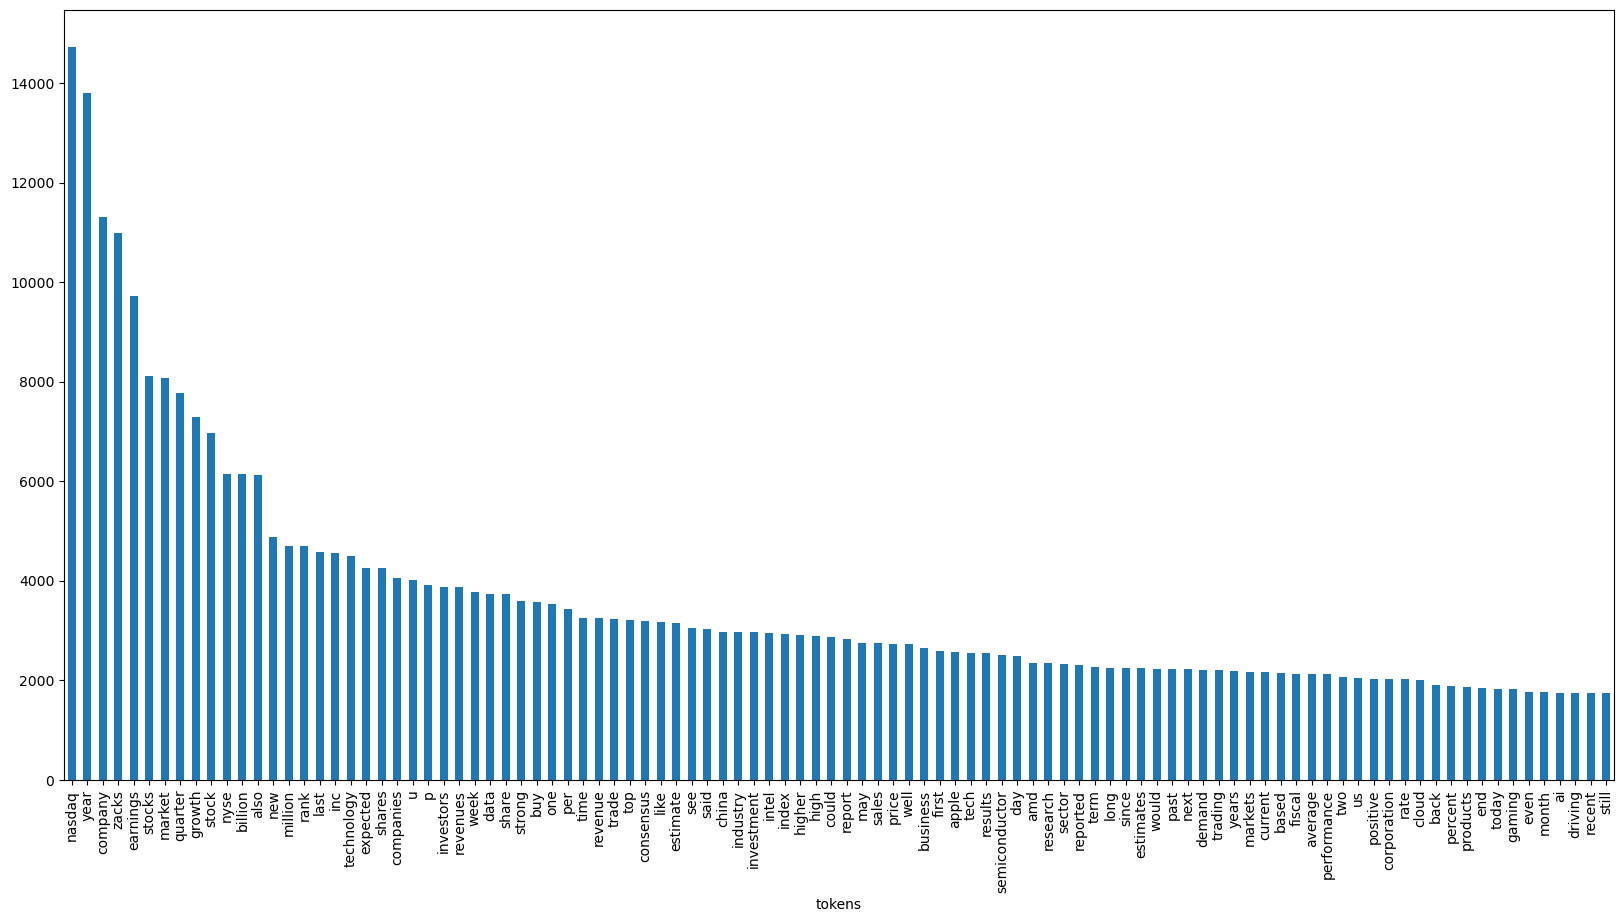

In [245]:
# Build corpus
corpus = df_news['tokens'].explode()
# Plot top 100 words in corpus
corpus.value_counts()[0:100].plot(kind='bar')

The histogram shows that the 'u' are 'p' tokens are prevalent in the corpus. As these are non valid words and probably leftovers HTML tags from the scraping process we choose to remove them.

<Axes: xlabel='tokens'>

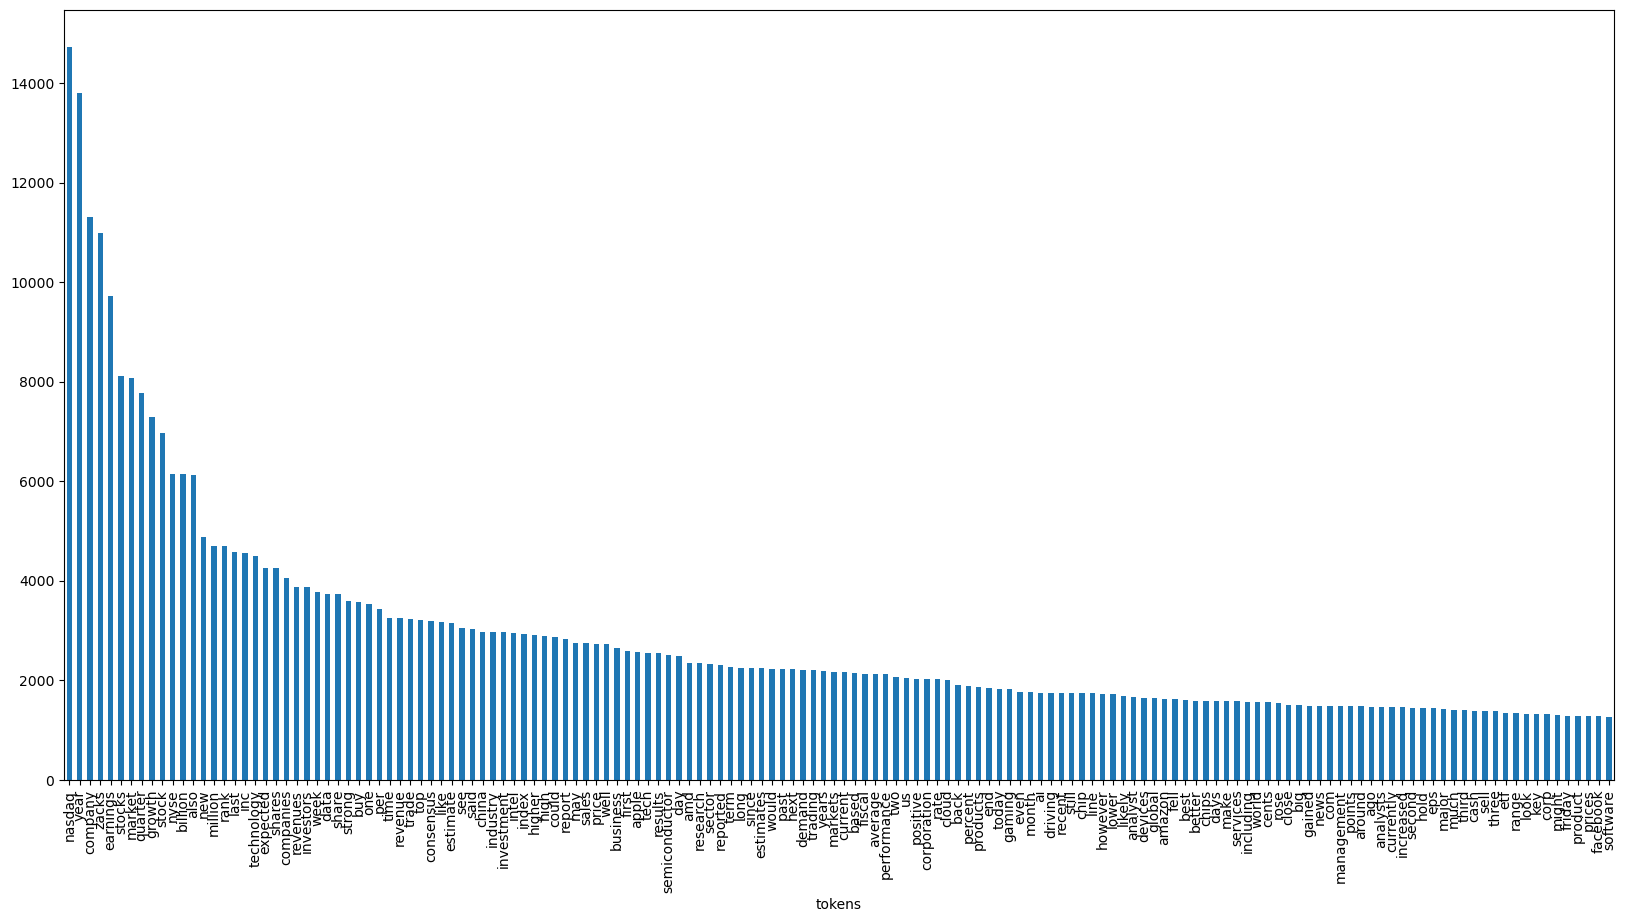

In [246]:
# Remove 'u' and 'nvpda' tokens
df_news['tokens'] = df_news['tokens'].apply(remove_tokens, remove_tokens=['u', 'p'])
df_news['content'] = df_news['tokens'].apply(join_tokens)
# Build corpus
corpus = df_news['tokens'].explode()
# Plot top 100 words in corpus
corpus.value_counts()[0:150].plot(kind='bar')

There are still alot of domain-specific keywords that do not really add information in the corpus. However, when using bi- or tri-grams these words may reveal patterns (e.g. nasdaq rose, stock market volatility) that may contain useful information. The choice is made to keep these words in the corpus. Due to this fact the choice has also been made to use an n_gram_range = (1,3) to keep TLAs (Three Letter Abbreviations) that are often used in domain specific jargon.

# BERTopic

In [247]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline
from umap import UMAP
from hdbscan import HDBSCAN
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [248]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)

In [249]:
def build_coherence_model(model, topics):
    # Extract vectorizer and analyzer from BERTopic
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in df_news['content']]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in model.get_topic(topic)] 
                for topic in range(len(set(topics))-1)]
    
    coherence_model_cv = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
    
        
    coherence_model_u_mass = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='u_mass')
    return coherence_model_cv, coherence_model_u_mass

## Model tuning

In [250]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(list(df_news['content']), show_progress_bar=False)

In [251]:
embeddings.shape

(3384, 384)

In [252]:
# Build custom UMAP model with set seed to eliminate random behaviour
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [253]:
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### Iteration 1

In [254]:
default_topic_model = BERTopic(umap_model=umap_model, n_gram_range=(1,3), verbose=True)
default_topics, default_probs = default_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-07 17:12:04,908 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-07 17:12:16,610 - BERTopic - Dimensionality - Completed ✓
2024-11-07 17:12:16,611 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-07 17:12:16,698 - BERTopic - Cluster - Completed ✓
2024-11-07 17:12:16,700 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-07 17:12:24,332 - BERTopic - Representation - Completed ✓


#### Qualitative analysis

In [255]:
default_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1124,"[year, nasdaq, company, zacks, earnings, stocks, market, growth, quarter, stock]"
1,0,154,"[amd, graphics, gpu, year, radeon, market, ryzen, quarter, processors, gaming]"
2,1,145,"[driving, self, self driving, autonomous, vehicles, cars, car, vehicle, technology, said]"
3,2,95,"[target, price target, price, shares, gaming, nasdaq, analyst, stock, data center, center]"
4,3,89,"[million, quarter, year, zacks, revenues, company, year year, earnings, zacks rank, rank]"
5,4,79,"[intel, ai, chips, data, nasdaq, new, cloud, hp, inference, technology]"
6,5,71,"[tech, nasdaq, stocks, growth, etf, technology, year, sector, fund, companies]"
7,6,65,"[year, quarter, gaming, billion, fiscal, revenues, company, million, year year, gpus]"
8,7,58,"[fed, week, dollar, nyse, percent, year, market, since, yield, china]"
9,8,58,"[apple, iphone, year, zacks, billion, company, nasdaq, quarter, services, earnings]"


In [256]:
default_topic_model.visualize_topics()

In [257]:
default_topic_model.visualize_heatmap()

In [258]:
hierarchical_topics = default_topic_model.hierarchical_topics(df_news['content'])
default_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 64/64 [00:01<00:00, 35.00it/s]


<Axes: xlabel='Representation'>

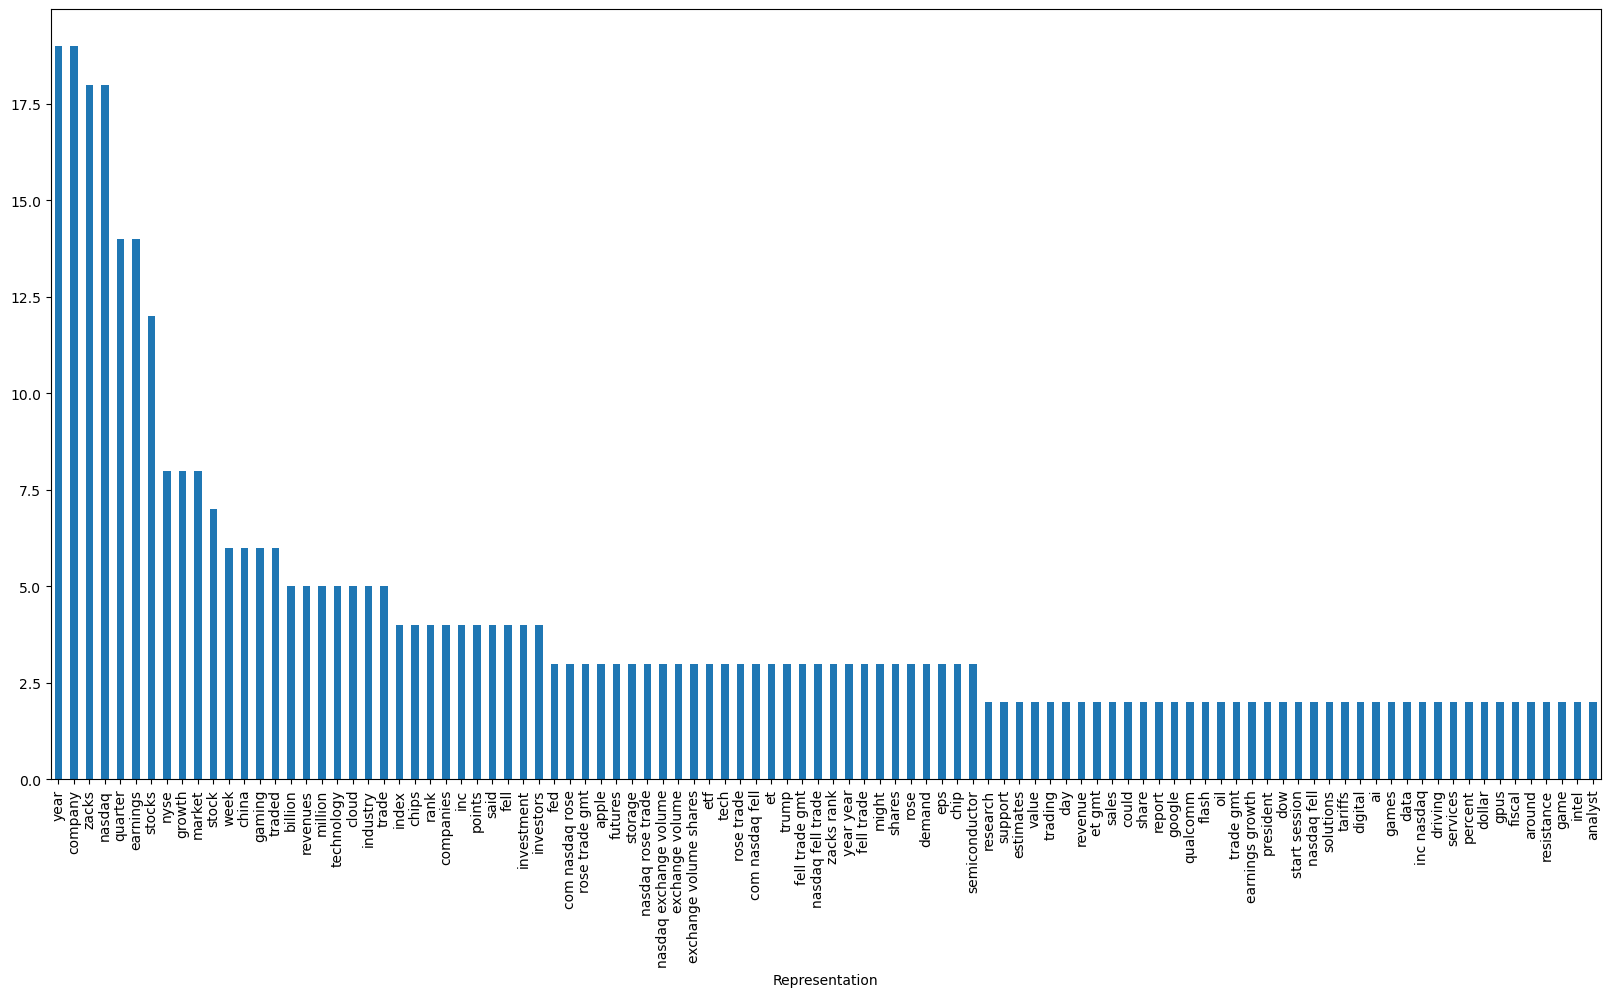

In [259]:
# Explore representation words
rep_words = default_topic_model.get_topic_info()['Representation'].explode()
rep_words.value_counts()[0:100].plot(kind='bar')

We can see in this histogram of representative tokens, that a lot of the topics are dominated by some tokens. Removing these tokens could improve topic quality, so lets try that. We take an arbitrary threshold of 10 and remove tokens above this threshold.

#### Quantitative analysis

In [260]:
it1_coherence_model_cv, it1_coherence_model_u_mass = build_coherence_model(default_topic_model, default_topics)
print(f'c_v: {it1_coherence_model_cv.get_coherence()}')
print(f'u_mass: {it1_coherence_model_u_mass.get_coherence()}')

c_v: 0.7287851626343985
u_mass: -1.1858813540567859


### Iteration 2

Remove tokens: 'year', 'company', 'zacks', 'nasdaq', 'quarter', 'earnings' and 'stocks'.

In [261]:
# Remove frequent tokens
df_news['tokens'] = df_news['tokens'].apply(remove_tokens, remove_tokens=['year', 'company', 'zacks', 'nasdaq', 'quarter', 'earnings', 'stocks'])
df_news['content'] = df_news['tokens'].apply(join_tokens)

In [262]:
default_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, n_gram_range=(1,3), verbose=True)
default_topics, default_probs = default_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-07 17:13:42,561 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-07 17:13:54,007 - BERTopic - Dimensionality - Completed ✓
2024-11-07 17:13:54,008 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-07 17:13:54,098 - BERTopic - Cluster - Completed ✓
2024-11-07 17:13:54,101 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-07 17:14:01,590 - BERTopic - Representation - Completed ✓


#### Qualitative analysis

In [263]:
default_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1069,"[market, growth, stock, billion, also, nyse, new, last, companies, week]"
1,0,180,"[million, revenues, rank, consensus, cents, estimate, consensus estimate, growth, share, per]"
2,1,171,"[driving, self, self driving, autonomous, vehicles, cars, car, vehicle, tesla, technology]"
3,2,169,"[nyse, trade, china, week, fed, dow, fell, market, trump, dollar]"
4,3,155,"[gaming, billion, revenues, million, games, fiscal, gpus, growth, game, consensus]"
5,4,154,"[amd, graphics, gpu, radeon, market, ryzen, processors, gaming, revenue, intel]"
6,5,123,"[semiconductor, industry, rank, growth, etf, china, stock, semiconductors, chip, market]"
7,6,95,"[target, price target, price, shares, gaming, analyst, stock, data center, center, rating]"
8,7,75,"[intel, ai, chips, data, cloud, new, inference, chip, market, technology]"
9,8,59,"[tech, etf, growth, technology, sector, fund, fang, companies, market, investors]"


We can see that the amount of topics has reduced from 65 to 45.

In [264]:
default_topic_model.visualize_topics()

In [265]:
default_topic_model.visualize_heatmap()

In [266]:
hierarchical_topics = default_topic_model.hierarchical_topics(df_news['content'])
default_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 44/44 [00:01<00:00, 35.33it/s]


Looking this hierarchical representation of the topics, the topics seem to be more coherent for human interpretation. There are however still closely related topics that are not clustered. If we threshold at 0.65 on the x-axis we can conclude that there around are around 29 topics.

<Axes: xlabel='Representation'>

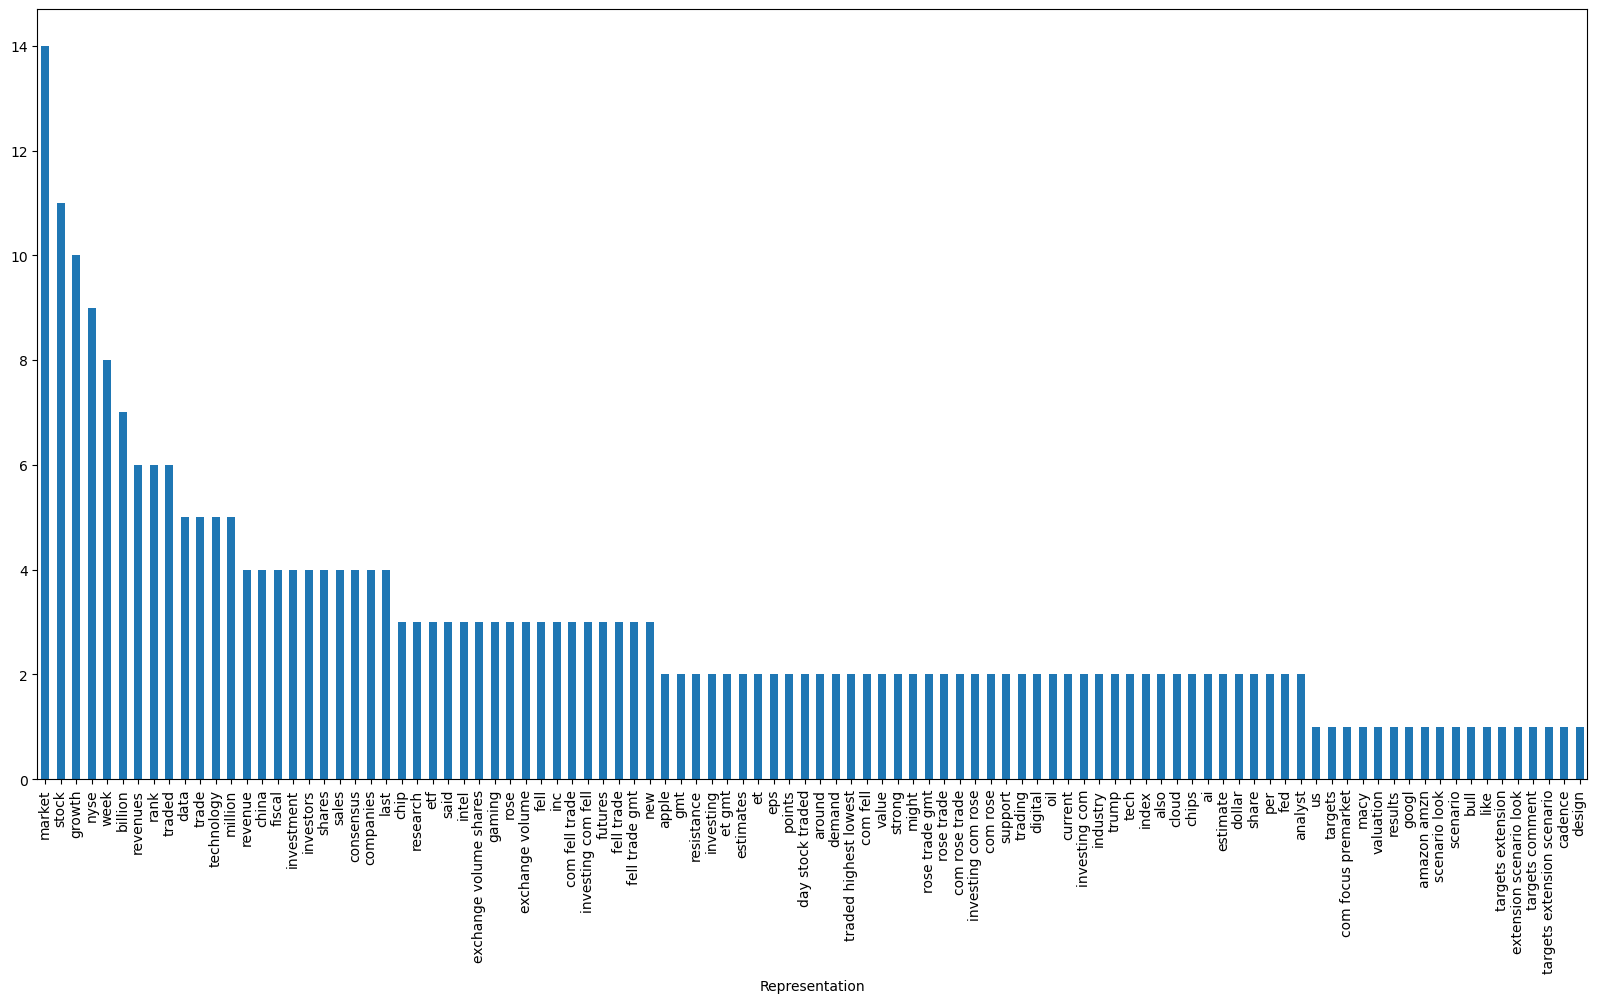

In [267]:
# Explore representation words
rep_words = default_topic_model.get_topic_info()['Representation'].explode()
rep_words.value_counts()[0:100].plot(kind='bar')

For the next iteration we try to further cluster closely related topics. This can be done by increasing the min_cluster_size of the HDBScan algorithm or just input the amount of wanted topics directly into the BERTopic model. The latter technique will be used.

#### Quantitative analysis

In [268]:
it2_coherence_model_cv, it2_coherence_model_u_mass = build_coherence_model(default_topic_model, default_topics)
print(f'c_v: {it2_coherence_model_cv.get_coherence()}')
print(f'u_mass: {it2_coherence_model_u_mass.get_coherence()}')

c_v: 0.7570812447253421
u_mass: -1.0915770209166613


### Iteration 3

Set nr_topics = 30 (29+1 for outliers)

In [269]:
default_topic_model = BERTopic(umap_model=umap_model, n_gram_range=(1,3), nr_topics=30, verbose=True)

In [270]:
default_topics, default_probs = default_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-07 17:15:14,432 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-07 17:15:25,806 - BERTopic - Dimensionality - Completed ✓
2024-11-07 17:15:25,807 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-07 17:15:25,892 - BERTopic - Cluster - Completed ✓
2024-11-07 17:15:25,893 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-07 17:15:33,647 - BERTopic - Representation - Completed ✓
2024-11-07 17:15:33,664 - BERTopic - Topic reduction - Reducing number of topics
2024-11-07 17:15:41,203 - BERTopic - Topic reduction - Reduced number of topics from 66 to 30


#### Qualitative analysis

In [271]:
default_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1124,"[market, growth, stock, billion, also, nyse, last, rank, new, technology]"
1,0,229,"[semiconductor, billion, growth, micron, industry, fiscal, estimate, stock, rank, demand]"
2,1,204,"[nyse, week, trade, fed, market, futures, fell, dow, china, last]"
3,2,164,"[million, revenues, consensus, growth, rank, estimate, cents, billion, share, consensus estimate]"
4,3,156,"[day, inc, stock, nyse, resistance, trading, week, support, back, market]"
5,4,154,"[amd, graphics, gpu, radeon, market, ryzen, revenue, gaming, processors, intel]"
6,5,148,"[traded, session traded range, highest lowest past, since start session, session traded, trade gmt, start session traded, day stock traded, traded highest lowest, stock traded highest]"
7,6,145,"[driving, self, self driving, autonomous, vehicles, cars, car, vehicle, technology, said]"
8,7,137,"[growth, stock, market, tech, investors, companies, technology, one, investment, shares]"
9,8,134,"[stock, target, price, price target, shares, gaming, analyst, nyse, market, data center]"


We can see that the amount of topics has reduced from 45 to 29.

In [272]:
hierarchical_topics = default_topic_model.hierarchical_topics(df_news['content'])
default_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 28/28 [00:00<00:00, 31.31it/s]


In [273]:
default_topic_model.visualize_heatmap()

<Axes: xlabel='Representation'>

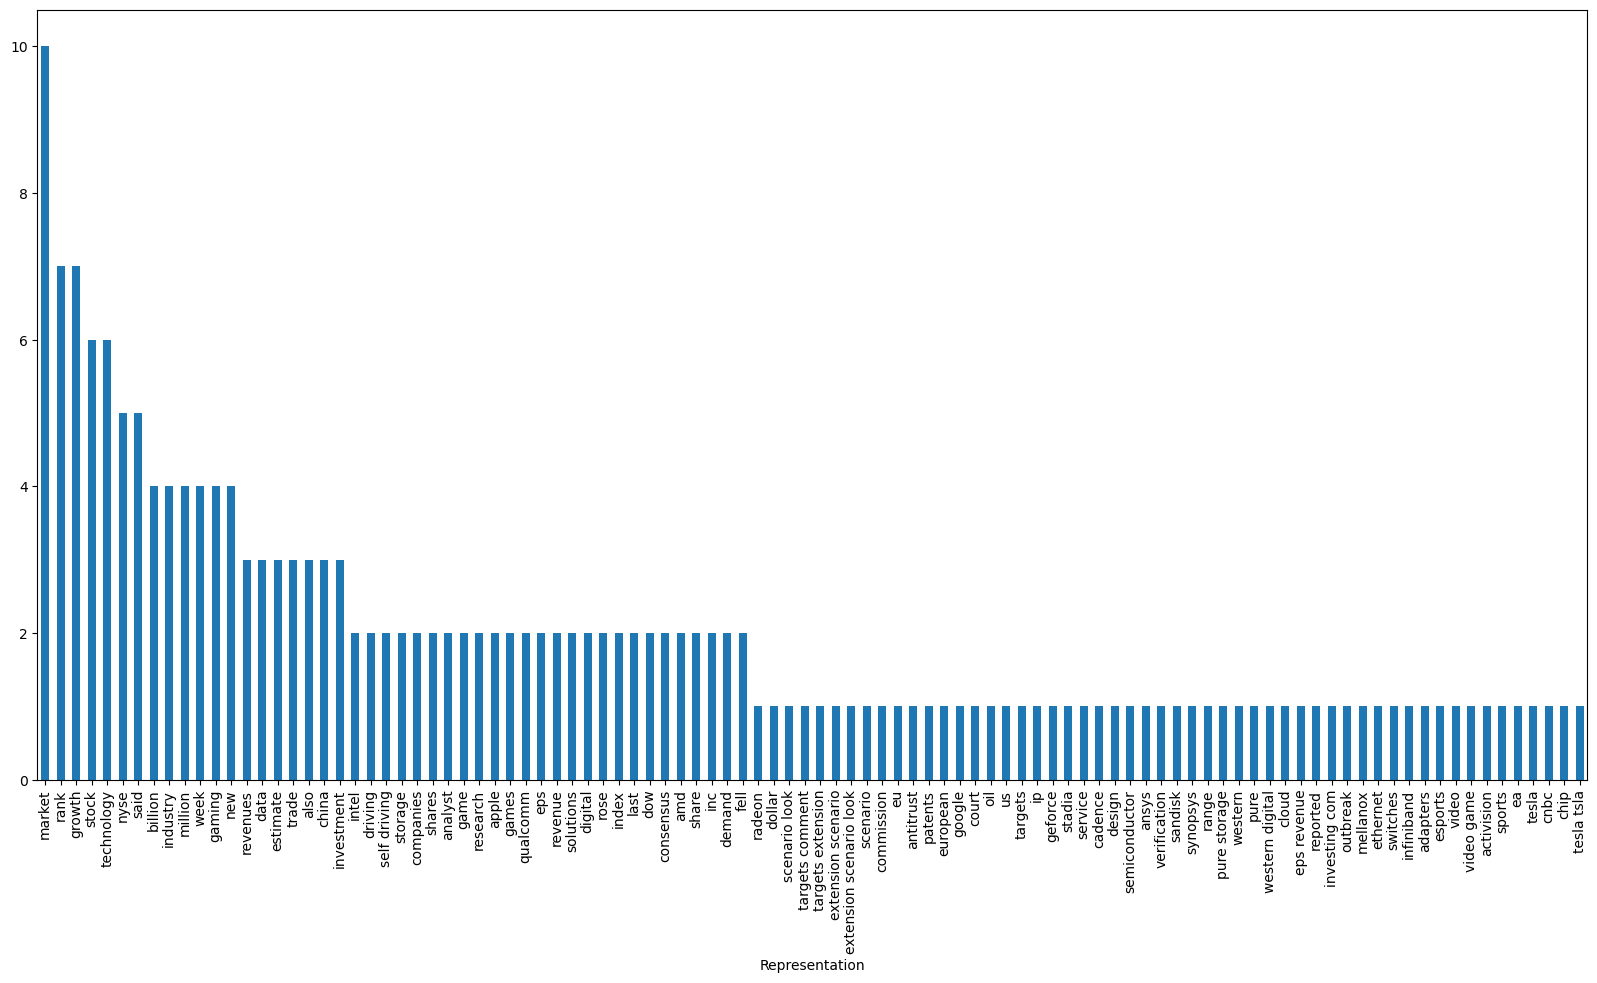

In [274]:
# Explore representation words
rep_words = default_topic_model.get_topic_info()['Representation'].explode()
rep_words.value_counts()[0:100].plot(kind='bar')

Lets try to remove some more low information tokens to further improve topic quality.

#### Quantitative analysis


In [275]:
it3_coherence_model_cv, it3_coherence_model_u_mass = build_coherence_model(default_topic_model, default_topics)
print(f'c_v: {it3_coherence_model_cv.get_coherence()}')
print(f'u_mass: {it3_coherence_model_u_mass.get_coherence()}')

c_v: 0.7560452050855131
u_mass: -1.1097419750488977


### Iteration 4

In [ ]:
# Remove frequent tokens
df_news['tokens'] = df_news['tokens'].apply(remove_tokens, remove_tokens=['said', 'market', 'rank'])
df_news['content'] = df_news['tokens'].apply(join_tokens)

In [286]:
default_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, n_gram_range=(1,3), nr_topics=30, verbose=True)
default_topics, default_probs = default_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-07 18:37:58,092 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-07 18:38:09,666 - BERTopic - Dimensionality - Completed ✓
2024-11-07 18:38:09,667 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-07 18:38:09,756 - BERTopic - Cluster - Completed ✓
2024-11-07 18:38:09,756 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-07 18:38:17,678 - BERTopic - Representation - Completed ✓
2024-11-07 18:38:17,695 - BERTopic - Topic reduction - Reducing number of topics
2024-11-07 18:38:25,527 - BERTopic - Topic reduction - Reduced number of topics from 46 to 30


#### Qualitative analysis

In [287]:
default_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1069,"[growth, stock, billion, also, nyse, new, last, companies, week, technology]"
1,0,221,"[million, revenues, consensus, growth, estimate, consensus estimate, cents, share, billion, per]"
2,1,214,"[nyse, week, trade, fed, china, might, last, dow, could, fell]"
3,2,190,"[semiconductor, micron, industry, billion, growth, stock, demand, chip, estimate, intel]"
4,3,171,"[driving, self, self driving, autonomous, vehicles, cars, car, vehicle, tesla, technology]"
5,4,155,"[gaming, billion, revenues, million, games, fiscal, gpus, growth, game, consensus]"
6,5,154,"[amd, graphics, gpu, radeon, ryzen, revenue, gaming, processors, intel, micro]"
7,6,150,"[traded, lowest past, since start session, session traded, range day stock, traded highest lowest, session traded range, lowest past seven, trade gmt, traded since start]"
8,7,132,"[growth, stock, investment, investors, tech, companies, one, shares, technology, like]"
9,8,113,"[day, stock, trading, resistance, support, week, call, short, index, nyse]"


On face value the topics seem to be distinguishable for humans. Furthemore the representative tokens in the topic also seem to paint a good picture of the contents of the topics.

In [288]:
hierarchical_topics = default_topic_model.hierarchical_topics(df_news['content'])
default_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 28/28 [00:00<00:00, 29.87it/s]


Looking at the hierarchical clustering graph we can see that the distance to each node is never really small. This means intra-topic similarity between topics is low. A low intra-topic similarity means the topics can be distinguished more easily.

In [289]:
default_topic_model.visualize_topics()

The intertopic distance map shows 5 distinct clusters. We can see th uppermost cluster is mostly about the semiconductor industry. The middle right cluster is about AI. The middle cluster is about chinese and american stock exchanges. The middle left cluster is about stock trading. The bottom cluster is about investments. These sets of clusters do contain their own subsets of topics.

In [290]:
default_topic_model.visualize_heatmap()

Looking at the similarity matrix, we can see that the topics still have a high similarity score. In our opinion this can be attributed to the fact that this is all financial texts. This means a lot of domain specific words are repeated in the corpus. This leads to higher similarity scores between topics.

#### Quantitative analysis


In [291]:
it4_coherence_model_cv, it4_coherence_model_u_mass = build_coherence_model(default_topic_model, default_topics)
print(f'c_v: {it4_coherence_model_cv.get_coherence()}')
print(f'u_mass: {it4_coherence_model_u_mass.get_coherence()}')

c_v: 0.7258984138372994
u_mass: -1.149923935570712
